In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

In [2]:
!pip install lightning
import lightning as L
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class BasicLightning(L.LightningModule):
  def __init__(self):
    super().__init__()

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)

    self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)


  def forward(self, input):

    input_to_top_relu = input * self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu = input * self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
    output = F.relu(input_to_final_relu)

    return output

In [5]:
input_doses = torch.linspace(start=0, end=1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [6]:
model = BasicLightning()
output_values = model(input_doses)

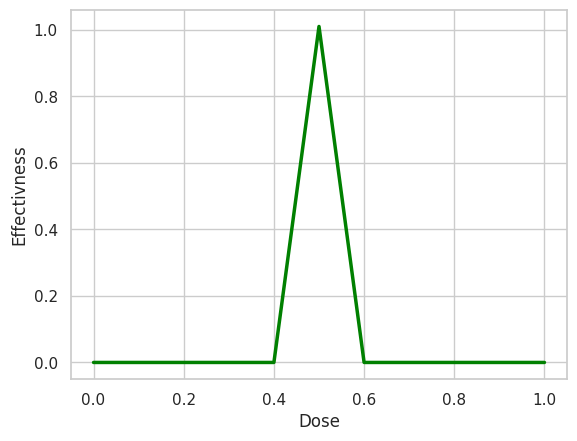

In [7]:
sns.set(style='whitegrid')
sns.lineplot(x=input_doses,
             y=output_values,
             color='green',
             linewidth=2.5)

plt.ylabel('Effectivness')
plt.xlabel('Dose')
plt.show()

In [8]:
class BasicLightningTrain(L.LightningModule):
  def __init__(self):
    super().__init__()

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)

    self.final_bias = nn.Parameter(torch.tensor(0.), requires_grad=True)

    self.learning_rate = 0.01


  def forward(self, input):

    input_to_top_relu = input * self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu = input * self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
    output = F.relu(input_to_final_relu)

    return output

  def configure_optimizers(self):

    return SGD(self.parameters(), lr=self.learning_rate)


  def training_step(self, batch, batch_idx):

    input_i, label_i = batch
    output_i = self.forward(input_i)
    loss = (output_i - label_i)**2

    return loss

In [9]:
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [10]:
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

model = BasicLightningTrain()

trainer = L.Trainer(max_epochs=34)

tuner = L.pytorch.tuner.Tuner(trainer)

lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=dataloader,
    min_lr=0.001,
    max_lr=1.0,
    early_stop_threshold=None
)

new_lr = lr_find_results.suggestion()
print(f"lr_find() suggests {new_lr:.5f} for the learning rate")

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

lr_find() suggests 0.00214 for the learning rate


In [11]:
model.learning_rate = new_lr

In [12]:
trainer.fit(model, train_dataloaders=dataloader)
print(f"Final bias: {model.final_bias.item()}")

Training: |          | 0/? [00:00<?, ?it/s]

Final bias: -2.170588970184326
